In [2]:
import os

# Make the directory if it doesn't exist
os.makedirs("f1_cache", exist_ok=True)

import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt

# Now enable cache
fastf1.Cache.enable_cache('f1_cache')


## import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt

# Enable cache
fastf1.Cache.enable_cache('f1_cache')  # Creates a cache directory

# Load a session (e.g., 2023 Monza qualifying)
session = fastf1.get_session(2023, 'Monza', 'Q')
session.load()

# Select two drivers
ver = session.laps.pick_driver('VER').pick_fastest()
lec = session.laps.pick_driver('LEC').pick_fastest()

# Get telemetry
ver_tel = ver.get_telemetry()
lec_tel = lec.get_telemetry()

# Plot speed comparison
plt.figure(figsize=(10, 6))
plt.plot(ver_tel['Distance'], ver_tel['Speed'], label='Verstappen')
plt.plot(lec_tel['Distance'], lec_tel['Speed'], label='Leclerc')
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.title('Fastest Lap Comparison: VER vs LEC (Monza 2023)')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
session = fastf1.get_session(2023, 'Monza', 'Q')
session.load()


core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '1', '16', '63', '11', '23', '81', '44', '4', '14', '22', '40', '27', '77', '2', '24', '10', '31', '20', '18']


In [6]:
import pandas as pd

# Get driver IDs
driver_ids = session.laps['Driver'].unique()

# Build driver info from session results
driver_info = []

for drv in driver_ids:
    drv_laps = session.laps.pick_drivers([drv])
    if drv_laps.empty:
        continue

    first_lap = drv_laps.iloc[0]
    fastest_lap = drv_laps.pick_fastest()

    driver_info.append({
        "Abbreviation": drv,
        "Driver Number": first_lap['DriverNumber'],
        "Team": first_lap['Team'],
        "Compound": fastest_lap['Compound'],
        "Fastest Lap Time": fastest_lap['LapTime']
    })

df_drivers = pd.DataFrame(driver_info).sort_values(by="Fastest Lap Time")
df_drivers.reset_index(drop=True, inplace=True)

df_drivers



,Abbreviation,Driver Number,Team,Compound,Fastest Lap Time
0,SAI,55,Ferrari,SOFT,0 days 00:01:20.294000
1,VER,1,Red Bull Racing,SOFT,0 days 00:01:20.307000
2,LEC,16,Ferrari,SOFT,0 days 00:01:20.361000
3,RUS,63,Mercedes,SOFT,0 days 00:01:20.671000
4,PER,11,Red Bull Racing,SOFT,0 days 00:01:20.688000
5,ALB,23,Williams,SOFT,0 days 00:01:20.760000
6,PIA,81,McLaren,SOFT,0 days 00:01:20.785000
7,HAM,44,Mercedes,SOFT,0 days 00:01:20.820000
8,NOR,4,McLaren,SOFT,0 days 00:01:20.979000
9,ALO,14,Aston Martin,SOFT,0 days 00:01:21.417000


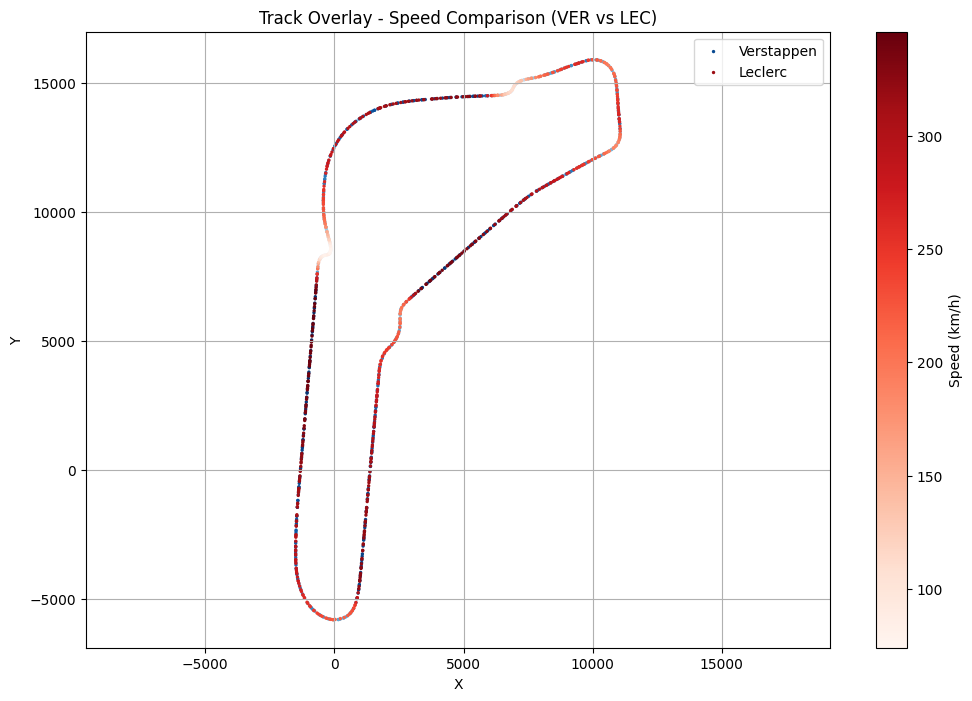

In [8]:
import matplotlib.pyplot as plt

# Get fastest laps
lap_ver = session.laps.pick_drivers(['VER']).pick_fastest()
lap_lec = session.laps.pick_drivers(['LEC']).pick_fastest()

# Get telemetry with position and speed
ver_tel = lap_ver.get_telemetry().add_distance()
lec_tel = lap_lec.get_telemetry().add_distance()

# Plot
plt.figure(figsize=(12, 8))

# Verstappen track path (blue)
sc1 = plt.scatter(
    ver_tel['X'], ver_tel['Y'],
    c=ver_tel['Speed'], cmap='Blues', s=2, label='Verstappen'
)

# Leclerc track path (red)
sc2 = plt.scatter(
    lec_tel['X'], lec_tel['Y'],
    c=lec_tel['Speed'], cmap='Reds', s=2, label='Leclerc'
)

plt.title('Track Overlay - Speed Comparison (VER vs LEC)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.legend(loc='upper right')
plt.colorbar(sc2, label='Speed (km/h)')
plt.grid(True)
plt.show()



In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
import seaborn as sns

class F1TireDegradationModel:
    """
    A class for predicting tire degradation in Formula 1 races.
    """
    
    def __init__(self):
        self.models = {}
        self.compounds = ['Soft', 'Medium', 'Hard', 'Intermediate', 'Wet']
        self.track_characteristics = {}
        
    def load_lap_time_data(self, file_path=None):
        """
        Load lap time data from a CSV file or create synthetic data for testing.
        
        Parameters:
        -----------
        file_path : str, optional
            Path to CSV file containing lap time data. If None, synthetic data is created.
        
        Returns:
        --------
        DataFrame containing lap time data
        """
        if file_path:
            try:
                return pd.read_csv(file_path)
            except FileNotFoundError:
                print(f"File not found: {file_path}. Creating synthetic data instead.")
        
        # Create synthetic data for testing
        np.random.seed(42)
        n_laps = 50
        
        # Create a DataFrame with synthetic lap data
        data = []
        
        # Generate data for each compound
        for compound in self.compounds[:3]:  # Only dry compounds for synthetic data
            base_time = {"Soft": 90.0, "Medium": 91.5, "Hard": 93.0}[compound]
            deg_factor = {"Soft": 0.08, "Medium": 0.05, "Hard": 0.03}[compound]
            
            for driver in ["VER", "HAM", "LEC", "NOR", "SAI"]:
                driver_skill = np.random.normal(0, 0.2)  # Driver variability
                
                for stint in range(1, 3):
                    stint_laps = np.random.randint(15, 30)
                    
                    for lap in range(1, stint_laps + 1):
                        # Base degradation model: t = t0 + a*lap^b + noise
                        noise = np.random.normal(0, 0.1)
                        
                        # More realistic degradation curve with exponential component
                        degradation = deg_factor * (lap**1.2) + noise
                        
                        # Add cliff effect for softs after certain laps
                        if compound == "Soft" and lap > 20:
                            degradation += 0.15 * (lap - 20)
                        
                        lap_time = base_time + degradation + driver_skill
                        
                        data.append({
                            'Driver': driver,
                            'Lap': lap,
                            'Stint': stint,
                            'Compound': compound,
                            'LapTime': lap_time,
                            'TrackTemp': np.random.normal(40, 5),
                            'TireAge': lap
                        })
        
        df = pd.DataFrame(data)
        
        # Add fuel effect (decreasing lap time as fuel burns off)
        for driver in df['Driver'].unique():
            driver_laps = df[df['Driver'] == driver].copy()
            total_laps = 0
            
            for stint in driver_laps['Stint'].unique():
                stint_data = driver_laps[driver_laps['Stint'] == stint]
                n_stint_laps = len(stint_data)
                
                fuel_effect = 0.02  # seconds per lap of fuel burned
                
                for i, idx in enumerate(stint_data.index):
                    fuel_saving = fuel_effect * (total_laps + i)
                    df.loc[idx, 'LapTime'] -= min(fuel_saving, 1.0)  # Cap fuel effect
                
                total_laps += n_stint_laps
        
        return df
    
    def analyze_track_characteristics(self, track_name, track_data=None):
        """
        Analyze track characteristics that affect tire degradation.
        
        Parameters:
        -----------
        track_name : str
            Name of the track
        track_data : dict, optional
            Pre-defined track data
            
        Returns:
        --------
        Dict with track characteristics
        """
        if track_data:
            self.track_characteristics[track_name] = track_data
            return track_data
        
        # Default track characteristics (sample data)
        track_db = {
            'Monza': {
                'abrasiveness': 2,  # 1-10 scale
                'avg_speed': 250,   # km/h
                'high_speed_corners': 3,
                'low_speed_corners': 2,
                'degradation_factor': 0.8
            },
            'Monaco': {
                'abrasiveness': 3,
                'avg_speed': 160,
                'high_speed_corners': 0,
                'low_speed_corners': 8,
                'degradation_factor': 0.5
            },
            'Silverstone': {
                'abrasiveness': 7,
                'avg_speed': 235,
                'high_speed_corners': 6,
                'low_speed_corners': 2,
                'degradation_factor': 1.2
            },
            'Barcelona': {
                'abrasiveness': 6,
                'avg_speed': 210,
                'high_speed_corners': 3,
                'low_speed_corners': 4,
                'degradation_factor': 1.0
            }
        }
        
        if track_name in track_db:
            self.track_characteristics[track_name] = track_db[track_name]
            return track_db[track_name]
        else:
            # Default values for unknown tracks
            default_chars = {
                'abrasiveness': 5,
                'avg_speed': 220,
                'high_speed_corners': 4,
                'low_speed_corners': 4,
                'degradation_factor': 1.0
            }
            self.track_characteristics[track_name] = default_chars
            return default_chars
    
    def train_model(self, lap_data, compound, degree=2):
        """
        Train a tire degradation model for a specific compound.
        
        Parameters:
        -----------
        lap_data : DataFrame
            Lap time data
        compound : str
            Tire compound (e.g., 'Soft', 'Medium', 'Hard')
        degree : int, optional
            Degree of polynomial regression
            
        Returns:
        --------
        Trained model
        """
        # Filter data for the specified compound
        compound_data = lap_data[lap_data['Compound'] == compound].copy()
        
        if len(compound_data) == 0:
            print(f"No data available for {compound} compound.")
            return None
        
        # Create features and target
        X = compound_data[['TireAge', 'TrackTemp']].values
        y = compound_data['LapTime'].values
        
        # Create and train the model
        model = make_pipeline(
            PolynomialFeatures(degree=degree, include_bias=False),
            LinearRegression()
        )
        
        model.fit(X, y)
        self.models[compound] = model
        
        # Evaluate the model
        y_pred = model.predict(X)
        mse = mean_squared_error(y, y_pred)
        print(f"Model for {compound} compound trained. MSE: {mse:.4f}")
        
        return model
    
    def train_all_models(self, lap_data, degrees=None):
        """
        Train models for all tire compounds.
        
        Parameters:
        -----------
        lap_data : DataFrame
            Lap time data
        degrees : dict, optional
            Dictionary mapping compounds to polynomial degrees
            
        Returns:
        --------
        Dict of trained models
        """
        if degrees is None:
            degrees = {compound: 2 for compound in self.compounds}
        
        for compound in self.compounds:
            if compound in lap_data['Compound'].unique():
                self.train_model(lap_data, compound, degrees.get(compound, 2))
            else:
                print(f"No data available for {compound} compound.")
        
        return self.models
    
    def predict_lap_time(self, compound, tire_age, track_temp, track_name=None):
        """
        Predict lap time based on tire compound, age, and track temperature.
        
        Parameters:
        -----------
        compound : str
            Tire compound
        tire_age : int
            Age of the tire in laps
        track_temp : float
            Track temperature in Celsius
        track_name : str, optional
            Track name for applying track-specific adjustments
            
        Returns:
        --------
        Predicted lap time
        """
        if compound not in self.models:
            raise ValueError(f"No model available for {compound} compound. Train the model first.")
        
        # Basic prediction
        X_pred = np.array([[tire_age, track_temp]])
        pred_time = self.models[compound].predict(X_pred)[0]
        
        # Apply track-specific adjustments if available
        if track_name and track_name in self.track_characteristics:
            track = self.track_characteristics[track_name]
            deg_factor = track['degradation_factor']
            
            # Adjust prediction based on track characteristics
            # More abrasive tracks increase degradation
            abrasive_effect = (track['abrasiveness'] / 5.0 - 1) * 0.1 * tire_age
            
            # High-speed corners increase degradation
            corner_effect = (track['high_speed_corners'] / 4.0 - 1) * 0.05 * tire_age
            
            pred_time += (abrasive_effect + corner_effect) * deg_factor
        
        return pred_time
    
    def simulate_race_stint(self, compound, stint_length, initial_track_temp=40, 
                           track_name=None, temp_evolution=None):
        """
        Simulate a race stint with the given tire compound.
        
        Parameters:
        -----------
        compound : str
            Tire compound
        stint_length : int
            Number of laps in the stint
        initial_track_temp : float, optional
            Initial track temperature
        track_name : str, optional
            Track name
        temp_evolution : function, optional
            Function that takes lap number and returns temperature change
            
        Returns:
        --------
        DataFrame with lap-by-lap predictions
        """
        if temp_evolution is None:
            # Default temperature evolution (slight increase, then plateau)
            def temp_evolution(lap):
                return min(lap * 0.2, 3)
        
        predictions = []
        
        for lap in range(1, stint_length + 1):
            track_temp = initial_track_temp + temp_evolution(lap)
            lap_time = self.predict_lap_time(compound, lap, track_temp, track_name)
            
            predictions.append({
                'Lap': lap,
                'Compound': compound,
                'TireAge': lap,
                'TrackTemp': track_temp,
                'PredictedLapTime': lap_time
            })
        
        return pd.DataFrame(predictions)
    
    def compare_strategies(self, strategies, race_length, track_name=None, 
                          initial_track_temp=40, temp_evolution=None):
        """
        Compare different tire strategies.
        
        Parameters:
        -----------
        strategies : list of dicts
            Each dict specifies a strategy with compound and stint length
        race_length : int
            Total race length in laps
        track_name : str, optional
            Track name
        initial_track_temp : float, optional
            Initial track temperature
        temp_evolution : function, optional
            Function for track temperature evolution
            
        Returns:
        --------
        DataFrame with strategy comparisons
        """
        strategy_results = []
        
        for i, strategy in enumerate(strategies):
            stints = strategy['stints']
            name = strategy.get('name', f"Strategy {i+1}")
            
            # Validate strategy
            total_laps = sum(stint['length'] for stint in stints)
            if total_laps < race_length:
                print(f"Warning: Strategy {name} only covers {total_laps} laps, not the full race length ({race_length}).")
            
            # Simulate each stint
            cumulative_time = 0
            lap_counter = 1
            
            for stint in stints:
                compound = stint['compound']
                stint_length = stint['length']
                
                # Add pit stop time except for first stint
                if lap_counter > 1:
                    pit_stop_time = 20  # typical pit stop time in seconds
                    cumulative_time += pit_stop_time
                
                # Simulate the stint
                stint_results = self.simulate_race_stint(
                    compound, stint_length, 
                    initial_track_temp + (temp_evolution(lap_counter) if temp_evolution else 0),
                    track_name, temp_evolution
                )
                
                # Add stint results to overall strategy
                for _, row in stint_results.iterrows():
                    strategy_results.append({
                        'Strategy': name,
                        'Overall_Lap': lap_counter,
                        'Stint': len(strategy_results) // stint_length + 1,
                        'Stint_Lap': row['Lap'],
                        'Compound': compound,
                        'LapTime': row['PredictedLapTime'],
                        'CumulativeTime': cumulative_time + row['PredictedLapTime']
                    })
                    
                    cumulative_time += row['PredictedLapTime']
                    lap_counter += 1
                    
                    # Stop if we've reached race length
                    if lap_counter > race_length:
                        break
                
                if lap_counter > race_length:
                    break
        
        return pd.DataFrame(strategy_results)
    
    def plot_degradation_curves(self, lap_data=None, compounds=None, max_laps=None, fitted=True):
        """
        Plot tire degradation curves.
        
        Parameters:
        -----------
        lap_data : DataFrame, optional
            Lap time data. If None, use synthetic data.
        compounds : list, optional
            List of compounds to plot. If None, plot all compounds.
        max_laps : int, optional
            Maximum number of laps to plot
        fitted : bool, optional
            Whether to plot fitted curves from models
            
        Returns:
        --------
        matplotlib figure
        """
        if lap_data is None:
            lap_data = self.load_lap_time_data()
        
        if compounds is None:
            compounds = [c for c in self.compounds if c in lap_data['Compound'].unique()]
        
        # Set up the figure
        plt.figure(figsize=(12, 8))
        
        for i, compound in enumerate(compounds):
            compound_data = lap_data[lap_data['Compound'] == compound]
            
            if len(compound_data) == 0:
                continue
                
            if max_laps:
                compound_data = compound_data[compound_data['TireAge'] <= max_laps]
            
            # Plot actual data points
            plt.scatter(compound_data['TireAge'], compound_data['LapTime'], 
                       alpha=0.3, label=f'{compound} (Actual)')
            
            # Plot fitted curve if requested and model exists
            if fitted and compound in self.models:
                # Create a range of tire ages for prediction
                max_age = max(compound_data['TireAge'])
                ages = np.arange(1, max_age + 1)
                
                # Use average track temperature for predictions
                avg_temp = compound_data['TrackTemp'].mean()
                
                # Make predictions
                X_pred = np.column_stack((ages, np.full_like(ages, avg_temp)))
                y_pred = self.models[compound].predict(X_pred)
                
                plt.plot(ages, y_pred, '-', linewidth=2, 
                        label=f'{compound} (Model)', 
                        color=plt.cm.tab10(i))
        
        plt.title('Tire Degradation Curves')
        plt.xlabel('Tire Age (Laps)')
        plt.ylabel('Lap Time (seconds)')
        plt.legend()
        plt.grid(True)
        
        return plt.gcf()
    
    def plot_strategy_comparison(self, strategy_results, highlight_fastest=True):
        """
        Plot strategy comparison.
        
        Parameters:
        -----------
        strategy_results : DataFrame
            Results from compare_strategies method
        highlight_fastest : bool, optional
            Whether to highlight the fastest strategy
            
        Returns:
        --------
        matplotlib figure
        """
        # Create subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot lap times for each strategy
        strategies = strategy_results['Strategy'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(strategies)))
        
        for i, strategy in enumerate(strategies):
            strategy_data = strategy_results[strategy_results['Strategy'] == strategy]
            
            # Plot lap times
            ax1.plot(strategy_data['Overall_Lap'], strategy_data['LapTime'], 
                   '-', color=colors[i], label=strategy)
            
            # Mark pit stops
            pit_stops = strategy_data[strategy_data['Stint_Lap'] == 1].iloc[1:]
            if not pit_stops.empty:
                ax1.scatter(pit_stops['Overall_Lap'], pit_stops['LapTime'], 
                          marker='x', s=100, color=colors[i])
        
        # Find best strategy
        if highlight_fastest and len(strategies) > 0:
            final_times = {}
            for strategy in strategies:
                strategy_data = strategy_results[strategy_results['Strategy'] == strategy]
                if not strategy_data.empty:
                    max_lap = strategy_data['Overall_Lap'].max()
                    final_time = strategy_data[strategy_data['Overall_Lap'] == max_lap]['CumulativeTime'].values[0]
                    final_times[strategy] = final_time
            
            if final_times:
                fastest_strategy = min(final_times, key=final_times.get)
                ax1.plot([], [], ' ', label=f'Fastest: {fastest_strategy}')
                
                # Plot delta to fastest strategy
                if len(strategies) > 1:
                    reference_strategy = fastest_strategy
                    ref_data = strategy_results[strategy_results['Strategy'] == reference_strategy]
                    
                    for i, strategy in enumerate(strategies):
                        if strategy == reference_strategy:
                            continue
                        
                        strategy_data = strategy_results[strategy_results['Strategy'] == strategy]
                        
                        # Join datasets on lap number
                        common_laps = set(strategy_data['Overall_Lap']).intersection(set(ref_data['Overall_Lap']))
                        
                        if common_laps:
                            s_times = {lap: time for lap, time in zip(strategy_data['Overall_Lap'], strategy_data['CumulativeTime'])}
                            r_times = {lap: time for lap, time in zip(ref_data['Overall_Lap'], ref_data['CumulativeTime'])}
                            
                            laps = sorted(common_laps)
                            deltas = [s_times[lap] - r_times[lap] for lap in laps]
                            
                            ax2.plot(laps, deltas, '-', color=colors[i], 
                                   label=f'{strategy} vs {reference_strategy}')
        
        # Set up the plots
        ax1.set_title('Race Strategy Comparison: Lap Times')
        ax1.set_xlabel('Lap')
        ax1.set_ylabel('Lap Time (seconds)')
        ax1.legend()
        ax1.grid(True)
        
        ax2.set_title('Time Delta to Reference Strategy')
        ax2.set_xlabel('Lap')
        ax2.set_ylabel('Delta (seconds)')
        ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
        ax2.grid(True)
        
        plt.tight_layout()
        return fig
    
    def visualize_compound_performance(self, lap_data=None, track_name=None):
        """
        Visualize tire compound performance across different conditions.
        
        Parameters:
        -----------
        lap_data : DataFrame, optional
            Lap time data
        track_name : str, optional
            Track name for additional context
            
        Returns:
        --------
        matplotlib figure
        """
        if lap_data is None:
            lap_data = self.load_lap_time_data()
        
        compounds = [c for c in self.compounds if c in lap_data['Compound'].unique()]
        
        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: Lap Time vs Tire Age by Compound
        for i, compound in enumerate(compounds):
            compound_data = lap_data[lap_data['Compound'] == compound]
            axes[0, 0].scatter(compound_data['TireAge'], compound_data['LapTime'], 
                             alpha=0.5, label=compound)
            
            # Add trend line
            if len(compound_data) > 1:
                tire_ages = compound_data['TireAge'].values
                lap_times = compound_data['LapTime'].values
                
                # Simple polynomial fit
                z = np.polyfit(tire_ages, lap_times, 2)
                p = np.poly1d(z)
                
                x_range = np.linspace(min(tire_ages), max(tire_ages), 100)
                axes[0, 0].plot(x_range, p(x_range), '-', 
                              label=f'{compound} trend', 
                              color=plt.cm.tab10(i))
        
        axes[0, 0].set_title('Lap Time vs Tire Age')
        axes[0, 0].set_xlabel('Tire Age (Laps)')
        axes[0, 0].set_ylabel('Lap Time (seconds)')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot 2: Lap Time Distribution by Compound
        for i, compound in enumerate(compounds):
            compound_data = lap_data[lap_data['Compound'] == compound]
            
            if len(compound_data) > 5:  # Need enough data for KDE
                try:
                    sns.kdeplot(compound_data['LapTime'], ax=axes[0, 1], label=compound)
                except Exception as e:
                    # Fallback to histogram if KDE fails
                    axes[0, 1].hist(compound_data['LapTime'], alpha=0.5, 
                                   label=compound, bins=10)
        
        axes[0, 1].set_title('Lap Time Distribution by Compound')
        axes[0, 1].set_xlabel('Lap Time (seconds)')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Plot 3: Scatter plot of Tire Age vs Track Temperature colored by Lap Time
        for i, compound in enumerate(compounds[:2]):  # Limit to 2 compounds for clarity
            compound_data = lap_data[lap_data['Compound'] == compound]
            
            if len(compound_data) > 10:
                ax = axes[1, i]
                scatter = ax.scatter(compound_data['TireAge'], compound_data['TrackTemp'],
                                  c=compound_data['LapTime'], cmap='YlOrRd', 
                                  alpha=0.7, s=30)
                ax.set_title(f'{compound} Lap Time: Age vs Track Temp')
                ax.set_xlabel('Tire Age (Laps)')
                ax.set_ylabel('Track Temperature (°C)')
                plt.colorbar(scatter, ax=ax, label='Lap Time (s)')
                ax.grid(True)
        
        # Plot 4: Degradation Rate by Compound
        deg_rates = []
        for compound in compounds:
            compound_data = lap_data[lap_data['Compound'] == compound]
            
            if len(compound_data) < 5:
                continue
                
            # Calculate degradation rate for each stint
            for driver in compound_data['Driver'].unique():
                for stint in compound_data[compound_data['Driver'] == driver]['Stint'].unique():
                    stint_data = compound_data[(compound_data['Driver'] == driver) & 
                                             (compound_data['Stint'] == stint)]
                    
                    if len(stint_data) < 5:
                        continue
                        
                    # Fit linear trend to get degradation rate
                    tire_ages = stint_data['TireAge'].values
                    lap_times = stint_data['LapTime'].values
                    
                    if len(tire_ages) > 1 and len(np.unique(tire_ages)) > 1:
                        z = np.polyfit(tire_ages, lap_times, 1)
                        deg_rate = z[0]  # Slope represents degradation rate
                        
                        deg_rates.append({
                            'Compound': compound,
                            'Driver': driver,
                            'Stint': stint,
                            'DegradationRate': deg_rate
                        })
        
        if deg_rates:
            deg_df = pd.DataFrame(deg_rates)
            try:
                sns.boxplot(x='Compound', y='DegradationRate', data=deg_df, ax=axes[1, 1])
            except Exception as e:
                # Fallback to a simple bar chart
                compound_groups = deg_df.groupby('Compound')['DegradationRate'].mean()
                axes[1, 1].bar(compound_groups.index, compound_groups.values)
                
            axes[1, 1].set_title('Tire Degradation Rate by Compound')
            axes[1, 1].set_xlabel('Compound')
            axes[1, 1].set_ylabel('Degradation Rate (sec/lap)')
            axes[1, 1].grid(True)
        
        # Add track info if available
        if track_name:
            fig.suptitle(f'Tire Performance Analysis - {track_name}', fontsize=16)
            if track_name in self.track_characteristics:
                track_info = self.track_characteristics[track_name]
                info_text = (f"Track: {track_name}\n"
                           f"Abrasiveness: {track_info['abrasiveness']}/10\n"
                           f"Avg Speed: {track_info['avg_speed']} km/h\n"
                           f"High-speed corners: {track_info['high_speed_corners']}\n"
                           f"Low-speed corners: {track_info['low_speed_corners']}")
                
                fig.text(0.02, 0.02, info_text, fontsize=10, 
                       bbox=dict(facecolor='white', alpha=0.5))
        else:
            fig.suptitle('Tire Performance Analysis', fontsize=16)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        return fig


# Example usage
if __name__ == "__main__":
    # Initialize the model
    print("Initializing F1 Tire Degradation Model...")
    model = F1TireDegradationModel()
    
    # Load data (synthetic in this case)
    print("Generating synthetic lap data...")
    lap_data = model.load_lap_time_data()
    
    # Analyze track
    print("Analyzing track characteristics for Silverstone...")
    track_info = model.analyze_track_characteristics('Silverstone')
    
    # Train models for each compound
    print("Training predictive models for each tire compound...")
    model.train_all_models(lap_data)
    
    # Visualize degradation curves
    print("Creating tire degradation curve visualization...")
    fig1 = model.plot_degradation_curves(lap_data)
    plt.savefig('tire_degradation_curves.png')
    plt.close(fig1)
    
    # Define race strategies
    print("Defining race strategies to evaluate...")
    strategies = [
        {
            'name': 'Soft-Hard',
            'stints': [
                {'compound': 'Soft', 'length': 15},
                {'compound': 'Hard', 'length': 35}
            ]
        },
        {
            'name': 'Medium-Medium',
            'stints': [
                {'compound': 'Medium', 'length': 25},
                {'compound': 'Medium', 'length': 25}
            ]
        },
        {
            'name': 'Soft-Medium-Medium',
            'stints': [
                {'compound': 'Soft', 'length': 12},
                {'compound': 'Medium', 'length': 20},
                {'compound': 'Medium', 'length': 18}
            ]
        }
    ]
    
    # Compare strategies
    print("Simulating and comparing race strategies...")
    strategy_results = model.compare_strategies(strategies, race_length=50, track_name='Silverstone')
    
    # Visualize strategy comparison
    print("Creating strategy comparison visualization...")
    fig2 = model.plot_strategy_comparison(strategy_results)
    plt.savefig('strategy_comparison.png')
    plt.close(fig2)
    
    # Visualize compound performance
    print("Creating compound performance visualization...")
    fig3 = model.visualize_compound_performance(lap_data, 'Silverstone')
    plt.savefig('compound_performance.png')
    plt.close(fig3)
    
    print("Analysis complete! Check the saved figures for visualization.")

Initializing F1 Tire Degradation Model...
Generating synthetic lap data...
Analyzing track characteristics for Silverstone...
Training predictive models for each tire compound...
Model for Soft compound trained. MSE: 0.2222
Model for Medium compound trained. MSE: 0.1228
Model for Hard compound trained. MSE: 0.0317
No data available for Intermediate compound.
No data available for Wet compound.
Creating tire degradation curve visualization...


<IPython.core.display.Javascript object>

Defining race strategies to evaluate...
Simulating and comparing race strategies...
Creating strategy comparison visualization...


<IPython.core.display.Javascript object>

Creating compound performance visualization...


<IPython.core.display.Javascript object>

Analysis complete! Check the saved figures for visualization.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class SimpleF1Gearbox:
    """A simplified model of a Formula 1 gearbox for basic analysis"""
    
    def __init__(self):
        # Basic gearbox parameters
        self.gear_ratios = {
            1: 14.0,   # First gear
            2: 11.0,   # Second gear
            3: 9.0,    # Third gear
            4: 7.0,    # Fourth gear
            5: 5.5,    # Fifth gear
            6: 4.5,    # Sixth gear
            7: 3.8,    # Seventh gear
            8: 3.2     # Eighth gear
        }
        self.final_drive = 3.5  # Final drive ratio
        self.wheel_radius = 0.33  # meters
        self.shift_time = 0.05  # seconds for gear change
        
        # Basic track data
        self.tracks = {
            'Monza': {'top_speed': 360, 'gear_usage': {8: 0.3, 7: 0.22}},  # High-speed track
            'Monaco': {'top_speed': 290, 'gear_usage': {3: 0.25, 2: 0.15}}  # Slow track
        }
        
        # Simple engine power model (RPM -> Power in kW)
        self.engine_power = {
            6000: 350,
            10000: 650,
            14000: 790
        }
    
    def calculate_speed(self, rpm, gear):
        """Calculate vehicle speed for a given RPM and gear"""
        total_ratio = self.gear_ratios[gear] * self.final_drive
        wheel_rpm = rpm / total_ratio
        speed_mps = wheel_rpm * (2 * np.pi * self.wheel_radius) / 60
        return speed_mps * 3.6  # Convert to km/h
    
    def calculate_rpm(self, speed_kph, gear):
        """Calculate engine RPM for a given speed and gear"""
        speed_mps = speed_kph / 3.6
        wheel_rpm = (speed_mps * 60) / (2 * np.pi * self.wheel_radius)
        total_ratio = self.gear_ratios[gear] * self.final_drive
        return wheel_rpm * total_ratio
    
    def simulate_acceleration(self, initial_speed=0, duration=5):
        """Simple acceleration simulation"""
        # Setup
        time_points = np.linspace(0, duration, 100)
        speed = np.zeros_like(time_points)
        rpm = np.zeros_like(time_points)
        gear = np.ones_like(time_points, dtype=int)
        
        # Initial conditions
        speed[0] = initial_speed
        rpm[0] = self.calculate_rpm(initial_speed, 1) if initial_speed > 0 else 1000
        
        # Simple simulation with fixed acceleration that decreases with speed
        for i in range(1, len(time_points)):
            # Determine if we need to shift up
            if rpm[i-1] > 13000 and gear[i-1] < 8:
                gear[i] = gear[i-1] + 1
                rpm[i] = self.calculate_rpm(speed[i-1], gear[i])
            else:
                gear[i] = gear[i-1]
                
            # Calculate acceleration (decreases with speed)
            accel = 10 * (1 - speed[i-1]/350)  # m/s²
            
            # Update speed and RPM
            speed[i] = speed[i-1] + accel * (time_points[i] - time_points[i-1])
            rpm[i] = self.calculate_rpm(speed[i], gear[i])
            
            # Keep RPM in valid range
            rpm[i] = min(rpm[i], 15000)
        
        return time_points, speed, rpm, gear
    
    def plot_acceleration(self):
        """Plot a simple acceleration simulation"""
        time, speed, rpm, gear = self.simulate_acceleration()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
        
        # Speed plot
        ax1.plot(time, speed, 'b-')
        ax1.set_ylabel('Speed (km/h)')
        ax1.set_title('F1 Gearbox Acceleration Simulation')
        ax1.grid(True)
        
        # RPM and gear plot
        ax2.plot(time, rpm, 'r-')
        ax2.set_ylabel('Engine RPM')
        ax2.set_xlabel('Time (s)')
        ax2.grid(True)
        
        # Add gear change indicators
        gear_changes = np.where(np.diff(gear) != 0)[0] + 1
        for g in gear_changes:
            ax2.axvline(x=time[g], color='green', linestyle='--', alpha=0.7)
            ax2.text(time[g], 14000, f'Gear {gear[g]}', fontsize=8)
        
        plt.tight_layout()
        return fig
    
    def compare_gear_ratios(self, new_ratios=None):
        """Compare current gear ratios with new ones"""
        if new_ratios is None:
            # Create a slightly modified set of ratios
            new_ratios = {k: v * 0.95 for k, v in self.gear_ratios.items()}
        
        # Calculate top speed in each gear at 14000 RPM
        speeds_current = [self.calculate_speed(14000, g) for g in range(1, 9)]
        speeds_new = [self.calculate_speed(14000, g) for g in range(1, 9)]
        
        # Plot comparison
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = list(range(1, 9))
        ax.plot(x, speeds_current, 'bo-', label='Current Ratios')
        ax.plot(x, speeds_new, 'ro-', label='New Ratios')
        
        ax.set_xlabel('Gear')
        ax.set_ylabel('Speed at 14000 RPM (km/h)')
        ax.set_title('Gear Ratio Comparison')
        ax.set_xticks(x)
        ax.grid(True)
        ax.legend()
        
        return fig
    
    def plot_track_comparison(self):
        """Compare gear usage on different tracks"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        gears = list(range(1, 9))
        
        # Create bar positions
        x = np.arange(len(gears))
        width = 0.35
        
        # Get gear usage for each track (with default values)
        monza_usage = [self.tracks['Monza']['gear_usage'].get(g, 0.05) for g in gears]
        monaco_usage = [self.tracks['Monaco']['gear_usage'].get(g, 0.05) for g in gears]
        
        # Create bars
        ax.bar(x - width/2, monza_usage, width, label='Monza')
        ax.bar(x + width/2, monaco_usage, width, label='Monaco')
        
        ax.set_xlabel('Gear')
        ax.set_ylabel('Usage (%)')
        ax.set_title('Gear Usage Comparison by Track')
        ax.set_xticks(x)
        ax.set_xticklabels(gears)
        ax.legend()
        
        return fig

# Example usage
if __name__ == "__main__":
    gearbox = SimpleF1Gearbox()
    
    # Run basic simulations
    accel_fig = gearbox.plot_acceleration()
    ratio_fig = gearbox.compare_gear_ratios()
    track_fig = gearbox.plot_track_comparison()
    
    # Save figures
    accel_fig.savefig('acceleration_simple.png')
    ratio_fig.savefig('gear_ratios_simple.png')
    track_fig.savefig('track_comparison_simple.png')
    
    print("Analysis complete! Check the saved visualization files.")